## Google Colab Integration

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Prerequisites

In [ ]:
# Utils
import datetime
import math
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import os
import pandas as pd
from random import randint
import scipy as sp
from scipy import optimize
from scipy.sparse.csgraph import connected_components
import time

# PyTorch
import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.init as init
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.utils.tensorboard import SummaryWriter

Checking GPU availability

In [ ]:
if torch.cuda.is_available():
    torch.device('cuda')

# 1) Utils

All of the required functions to facilitate our future endeavours.

## Data Loader

In [ ]:
def Graph_load_batch(min_num_nodes=20, max_num_nodes=1000, name='ENZYMES', node_attributes=True, graph_labels=True):
    '''
    Loads many graphs, e.g. ENZYMES.
    :return: a list of graphs
    '''

    print('Loading graph dataset: ' + str(name))
    G = nx.Graph()

    # Loading the data from file

    path = '/content/gdrive/My Drive/' + name + '/'
    data_adj = np.loadtxt(path + name + '_A.txt', delimiter=',').astype(int)

    if node_attributes:
        data_node_att = np.loadtxt(path + name + '_node_attributes.txt', delimiter=',')

    data_node_label = np.loadtxt(path + name + '_node_labels.txt', delimiter=',').astype(int)
    data_graph_indicator = np.loadtxt(path + name + '_graph_indicator.txt', delimiter=',').astype(int)

    if graph_labels:
        data_graph_labels = np.loadtxt(path + name + '_graph_labels.txt', delimiter=',').astype(int)

    data_tuple = list(map(tuple, data_adj))
    G.add_edges_from(data_tuple)

    for i in range(data_node_label.shape[0]):
        if node_attributes:
            G.add_node(i + 1, feature=data_node_att[i])
        G.add_node(i + 1, label=data_node_label[i])
    G.remove_nodes_from(list(nx.isolates(G)))

    graph_num = data_graph_indicator.max()
    node_list = np.arange(data_graph_indicator.shape[0]) + 1

    graphs = []
    max_nodes = 0

    for i in range(graph_num):
        nodes = node_list[data_graph_indicator == i + 1]
        G_sub = G.subgraph(nodes)
        if graph_labels:
            G_sub.graph['label'] = data_graph_labels[i]

        if G_sub.number_of_nodes() >= min_num_nodes and G_sub.number_of_nodes() <= max_num_nodes:
            graphs.append(G_sub)
            if G_sub.number_of_nodes() > max_nodes:
                max_nodes = G_sub.number_of_nodes()

    print(f'Data ({len(graphs)} entries) loaded successfully.')
    return graphs

## Graph Matrices

In [ ]:
## TODO: input number of features
def feature_matrix(g, max_nodes):
    features = nx.get_node_attributes(g, 'label')
    mat_rep = np.zeros((max_nodes, 3))
    for i, (k, v) in enumerate(features.items()):
        mat_rep[i][v - 1] = 1
    return mat_rep

In [ ]:
def adjacency_matrix(graph, max_size, min_size):
    '''
    Gets a graph as an input
    :return: graph's feautre matrix and padded adjacency matrix
    '''
    if len(graph.nodes()) > max_size or len(graph.nodes()) < min_size:
        return None
    adj = nx.to_numpy_matrix(graph)
    graph_length = len(graph)
    padded_adj = np.pad(adj, [(0, max_size - graph_length), (0, max_size - graph_length)])
    return padded_adj

In [ ]:
def recover_adj(x, max_nodes):
    adj = torch.zeros(max_nodes, max_nodes).cuda()
    adj[torch.triu(torch.ones(max_nodes, max_nodes)) == 1] = x
    diag = torch.diag(torch.diag(adj, 0))
    recovered = adj + torch.transpose(adj, 0, 1) - diag
    return recovered

## Synthetic Graph Generators



In [ ]:
# def generate_random_graph(min_num_nodes=10, max_num_nodes=25, graph_type='random', directed=False, seed=123456, **kwargs):
#     if graph_type == 'random':
#         G = nx.gnp_random_graph(randint(min_num_nodes, max_num_nodes), kwargs['p1'], seed=seed, directed=directed)
#     elif graph_type == 'erdos_renyi':
#         G = nx.erdos_renyi_graph(randint(min_num_nodes, max_num_nodes), kwargs['p1'], seed=seed, directed=directed)
#     elif graph_type == 'lobster':
#         G = nx.random_lobster(randint(min_num_nodes, max_num_nodes), kwargs['p1'], kwargs['p2'], seed=seed)
#     elif graph_type == 'barabasi_albert':
#         G = nx.barabasi_albert_graph(randint(min_num_nodes, max_num_nodes), kwargs['barabasi_m'], seed=seed)

#     return G

## Graph Display Tool

In [ ]:
def show_graph(model):
    reconstruct = model.generate()
    nx.draw(nx.from_numpy_matrix(np.rint(reconstruct.cpu().numpy())))
    plt.show()

In [ ]:
# nx.draw(generate_random_graph(graph_type='lobster', p1=.1, p2=.05))

In [ ]:
graphs = Graph_load_batch(min_num_nodes=10, name='ENZYMES')

Loading graph dataset: ENZYMES
Data (587 entries) loaded successfully.


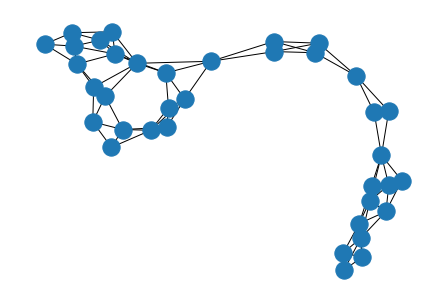

In [ ]:
nx.draw(graphs[0])

## Statistics Computing Functions
Function defenitions for computing several key graph attributes.

In [ ]:
def statistics_LCC(A_in):
    '''
    Compute the size of the largest connected component (LCC)

    Parameters
    ----------
    A_in: sparse matrix or np.array
          The input adjacency matrix.
    Returns
    -------
    Size of LCC

    '''
    unique, counts = np.unique(connected_components(A_in)[1], return_counts=True)
    LCC = np.where(connected_components(A_in)[1] == np.argmax(counts))[0]
    return LCC

In [ ]:
def statistics_degrees(A_in):
    '''
    Compute min, max, mean degree

    Parameters
    ----------
    A_in: sparse matrix or np.array
          The input adjacency matrix.
    Returns
    -------
    d_max. d_min, d_mean
    '''

    degrees = A_in.sum(axis=0)
    return np.max(degrees), np.min(degrees), np.mean(degrees)

In [ ]:
def statistics_wedge_count(A_in):
    '''
    Compute the wedge count of the input graph

    Parameters
    ----------
    A_in: sparse matrix or np.array
          The input adjacency matrix.

    Returns
    -------
    The wedge count.
    '''

    degrees = A_in.sum(axis=0).flatten()
    return float(np.sum(np.array([0.5 * x * (x - 1) for x in degrees])))

In [ ]:
def statistics_claw_count(A_in):
    '''
    Compute the claw count of the input graph

    Parameters
    ----------
    A_in: sparse matrix or np.array
          The input adjacency matrix.

    Returns
    -------
    Claw count
    '''

    degrees = A_in.sum(axis=0).flatten()
    return float(np.sum(np.array([1 / 6. * x * (x - 1) * (x - 2) for x in degrees])))

In [ ]:
def statistics_triangle_count(A_in):
    '''
    Compute the triangle count of the input graph

    Parameters
    ----------
    A_in: sparse matrix or np.array
          The input adjacency matrix.
    Returns
    -------
    Triangle count
    '''

    A_graph = nx.from_numpy_matrix(A_in)
    triangles = nx.triangles(A_graph)
    t = np.sum(list(triangles.values())) / 3
    return int(t)

In [ ]:
def statistics_gini(A_in):
    '''
    Compute the Gini coefficient of the degree distribution of the input graph

    Parameters
    ----------
    A_in: sparse matrix or np.array
          The input adjacency matrix.

    Returns
    -------
    Gini coefficient
    '''

    n = A_in.shape[0]
    degrees = A_in.sum(axis=0).flatten()
    degrees_sorted = np.sort(degrees)
    G = (2 * np.sum(np.array([i * degrees_sorted[i] for i in range(len(degrees))]))) / (n * np.sum(degrees)) - (n + 1) / n
    return float(G)

In [ ]:
def statistics_compute_cpl(A_in):
    '''
    Compute characteristic path length

    Parameters
    ----------
    A_in: sparse matrix or np.array
          The input adjacency matrix.

    Returns
    -------
    CPL
    '''

    P = sp.csgraph.shortest_path(sp.csr_matrix(A_in))
    return P[((1 - np.isinf(P)) * (1 - np.eye(P.shape[0]))).astype(np.bool)].mean()

In [ ]:
def compute_graph_statistics(A_in):
    '''
    Compute all of the graph attributes

    Parameters
    ----------
    A_in: sparse matrix
          The input adjacency matrix.

    Returns
    -------
    Dictionary containing the following statistics:
             * Maximum, minimum, mean degree of nodes
             * Size of the largest connected component (LCC)
             * Wedge count
             * Claw count
             * Triangle count
             * Gini coefficient
             * Number of connected components
             * Characteristic path length
    '''

    A = A_in.copy()

    # assert((A == A.T).all())
    A_graph = nx.from_numpy_matrix(A).to_undirected()
    statistics = {}
    d_max, d_min, d_mean = statistics_degrees(A)

    # Degree Statistics
    statistics['d_max'] = d_max
    statistics['d_min'] = d_min
    statistics['d'] = d_mean

    # Node Number & Edge Number
    statistics['node_num'] = A_graph.number_of_nodes()
    statistics['edge_num'] = A_graph.number_of_edges()

    # Largest Connected Component
    LCC = statistics_LCC(A)
    statistics['LCC'] = LCC.shape[0]

    # Wedge Count
    # statistics['wedge_count'] = statistics_wedge_count(A)

    # Claw Count
    # statistics['claw_count'] = statistics_claw_count(A)

    # Triangle Count
    statistics['triangle_count'] = statistics_triangle_count(A)

    # Gini Coefficient
    statistics['gini'] = statistics_gini(A)

    # Clustering Coefficient
    # statistics['clustering_coefficient'] = 3 * statistics['triangle_count'] / (statistics['claw_count']+1)

    # Number of Connected Components
    statistics['n_components'] = connected_components(A)[0]

    # Characteristic Path Length
    # statistics['cpl'] = statistics_compute_cpl(A)

    return statistics

In [ ]:
compute_graph_statistics(nx.adjacency_matrix(graphs[1]))

{'LCC': 23,
 'd': 4.434782608695652,
 'd_max': 6,
 'd_min': 3,
 'edge_num': 51,
 'gini': -1.0434782608695652,
 'n_components': 1,
 'node_num': 23,
 'triangle_count': 33}

## Save and Load

In [ ]:
def save_model_to_drive(base_dir, model, optim, epoch, loss):
    if not os.path.isdir(base_dir):
        os.mkdir(base_dir)
        torch.save(
        {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': loss,
        }, f'{base_dir}/MODEL_ALAJ_{epoch}.pkl')


def load_model_from_drive(base_dir, model, optimizer):
    latest_path = sorted(os.listdir(base_dir))
    print(latest_path)
    latest_path = latest_path[-1]
    checkpoint = torch.load(f'{base_dir}/{latest_path}')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return model, optimizer, epoch, loss


def load_model_only_from_drive(base_dir, model):
    latest_path = sorted(os.listdir(base_dir))[-1]
    checkpoint = torch.load(f'{base_dir}/{latest_path}')
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

# 2) Model

The model definition and its blueprints.

## Convolution
The definition of graph convoultions (convolution layers) and its blueprint.

In [ ]:
class GraphConv(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.weight = nn.Parameter(torch.FloatTensor(input_dim, output_dim).cuda())
        self.relu = nn.ReLU()

    def forward(self, X, Adj):
        '''
        X and Adj are the actual feature and adjacency matrices, respectively.
        '''
        Y = torch.matmul(Adj, X)
        Y = torch.matmul(Y, self.weight.double())

        return Y

## Encoder
Encoder for our *VAE*.

In [ ]:
class GraphEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, emb_dim):
        '''
        emb_dim must be max_nodes
        '''
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.emb_dim = emb_dim
        super(GraphEncoder, self).__init__()

        self.conv1 = GraphConv(input_dim=input_dim, output_dim=hidden_dim).cuda()
        self.relu = nn.ReLU()
        self.conv2 = GraphConv(input_dim=hidden_dim, output_dim=emb_dim).cuda()
        self.linear_miu = nn.Linear(emb_dim, emb_dim, dtype=torch.float32).cuda()
        self.linear_sigma = nn.Linear(emb_dim, emb_dim, dtype=torch.float32).cuda()

        for layer in self.modules():
            if isinstance(layer, GraphConv):
                layer.weight.data = init.xavier_normal_(layer.weight.data.double(), gain=nn.init.calculate_gain('relu'))

    def forward(self, X, Adj):
        '''
        X is the feature matrix, NOT the embedding
        '''
        X = self.conv1(X, Adj)
        X = self.relu(X)
        X = self.conv2(X, Adj)

        # Sum the node features to obtain the graph's feature matrix
        X = torch.mean(X, 0, dtype=torch.float64)
        miu = self.linear_miu(X.float())
        sigma = self.linear_sigma(X.float())

        return miu, sigma

## Decoder
Decoder for our *VAE*.

In [ ]:
class GraphDecoder(nn.Module):
    def __init__(self, emb_dim, hidden_dim, max_nodes):
      output_dim = max_nodes * (max_nodes + 1) // 2
      super(GraphDecoder, self).__init__()

      self.conv1 = nn.Linear(emb_dim, hidden_dim, dtype=torch.float32).cuda()
      self.relu = nn.ReLU()
      self.conv2 = nn.Linear(hidden_dim, output_dim, dtype=torch.float32).cuda()

      for layer in self.modules():
            if isinstance(layer, GraphConv):
                layer.weight.data = init.xavier_normal_(layer.weight.data, gain=nn.init.calculate_gain('relu'))

    def forward(self, X):
        X = self.conv1(X)
        X = self.relu(X)
        X = self.conv2(X)

        return torch.sigmoid(X)

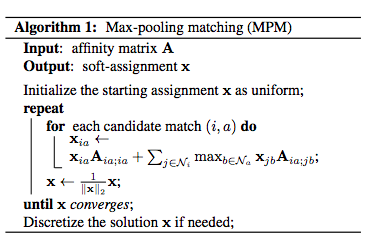

## AlajVAE
Our model definitions and blueprints.

In [ ]:
class AlajVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, emb_dim, max_nodes):
      super(AlajVAE, self).__init__()

      self.encoder = GraphEncoder(input_dim=input_dim, hidden_dim=hidden_dim, emb_dim=emb_dim).cuda()
      self.decoder = GraphDecoder(emb_dim=emb_dim, hidden_dim=hidden_dim, max_nodes=max_nodes).cuda()

      self.emb_dim = emb_dim
      self.max_nodes = max_nodes

    def generate(self):
        z = torch.autograd.Variable(torch.rand(self.emb_dim)).cuda()
        out = self.decoder(z)
        rec_adj_tensor = recover_adj(out.data, self.max_nodes)
        return rec_adj_tensor


    def similarity_function(self, adj, adj_rec, matching_features, matching_features_rec):
        '''
        Specifically, the predicted adjacency matrix eA 2 [0, 1]k⇥k contains both node probabilities
        eAa,a and edge probabilities eAa,b for nodes a 6= b
        '''

        similarities_matrix = torch.zeros(self.max_nodes, self.max_nodes, self.max_nodes, self.max_nodes).cuda()
        for i in range(self.max_nodes):
          for j in range(0, self.max_nodes):
                    if i == j:
                        for a in range(self.max_nodes):
                            similarities_matrix[i, j, a, a] = ((1 / (abs(matching_features[i] - matching_features_rec[a]) + 1)) * adj_rec[a, a])
                    else:
                        for a in range(self.max_nodes):
                            for b in range(self.max_nodes):
                                if b == a:
                                    continue
                                similarities_matrix[i, j, a, b] = (adj[i, j]* adj_rec[a, b]* adj_rec[a, a]* adj_rec[b, b])
        return similarities_matrix

    def mp_matching(self, init, S, max_iters=50):
        '''
        Max-pooling Matching implementation.
        '''
        x = init
        for it in range(max_iters):
            y = torch.zeros(self.max_nodes, self.max_nodes).cuda()
            for i in range(self.max_nodes):
                for a in range(self.max_nodes):
                    y[i, a] = x[i, a] * S[i, i, a, a]
                    neighbours = sum([torch.max(x[j, :] * S[i, j, a, :]) for j in range(self.max_nodes) if j != i])
                    y[i, a] += neighbours.detach().item()
            norm = torch.norm(y)
            x = y / norm
        return x

    def forward(self, X, Adj):
        miu, sigma = self.encoder(X, Adj)
        self.sigma = sigma
        self.miu = miu
        eps = torch.autograd.Variable(torch.randn(sigma.size())).cuda()
        z = eps * sigma + miu
        self.z = z
        self.eps = eps
        out = self.decoder(z)
        self.out = out

        rec_adj_tensor = recover_adj(out, self.max_nodes)
        out_features = torch.sum(rec_adj_tensor, 1)
        adj_features = torch.sum(Adj, 1)

        S = self.similarity_function(Adj, rec_adj_tensor, adj_features, out_features).cuda()
        self.S = S
        init_corr = 1 / self.max_nodes
        init_assignment = torch.ones(self.max_nodes, self.max_nodes).cuda() * init_corr
        assignment = self.mp_matching(init_assignment, S)

        adj_permuted = Adj.data
        adj_vectorized = adj_permuted[torch.triu(torch.ones(self.max_nodes, self.max_nodes)) == 1].squeeze_()
        self.adj_vectorized = adj_vectorized
        adj_vectorized_var = torch.autograd.Variable(adj_vectorized, requires_grad=False).cuda()
        self.adj_vectorized_var = adj_vectorized_var

        # NOTE: first = truth, second = predicted.
        rec_loss = F.binary_cross_entropy(out, adj_vectorized_var.float())
        normalized_kl = torch.mean((-0.5 * torch.sum(1 + sigma - miu.pow(2) - sigma.exp())))
        total_loss = rec_loss + normalized_kl

        return total_loss

# 3) Train and Test Functions

In [ ]:
data = Graph_load_batch(min_num_nodes=15, max_num_nodes=20, name='ENZYMES')

Loading graph dataset: ENZYMES
Data (67 entries) loaded successfully.


In [ ]:
def train_model(model, dataset, epochs, min_nodes, max_nodes, print_interval=1, resume=False):
    base_dir = '/content/gdrive/MyDrive/Alaj_output'

    # Using Adam Optimizer
    optim = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

    model.train()
    start = time.time()
    temp = start
    total_loss = 0
    writer = SummaryWriter()
    start_epoch = -1

    if resume:
        model, optim, start_epoch, loss = load_model_from_drive(base_dir, model, optim)
        print(f'Resuming from epoch #{start_epoch + 1}.')

    for epoch in range(start_epoch + 1, epochs):
        for batch, graph in enumerate(dataset):
            adj, features = torch.tensor(adjacency_matrix(graph, max_nodes, min_nodes)).cuda(), torch.tensor(feature_matrix(graph, max_nodes)).cuda()
            loss = model(features, adj)
            optim.zero_grad()
            writer.add_scalar('Loss/Train', float(loss), epoch)
            loss.backward()
            optim.step()
            total_loss += loss.item()
            if (epoch + 1) % print_interval == 0:
                loss_avg = total_loss / print_interval
                print(f'Time = {datetime.timedelta(seconds=round(time.time() - start))},\t\t' \
                      f'Epoch #{epoch + 1},\t' \
                      f'Loss = {loss_avg:.3f},\t\t' \
                      f'{round(time.time() - temp)} seconds per {print_interval} iteration(s).')
                total_loss = 0
                temp = time.time()

        # Saving the trained model on each epoch (saving checkpoints)
        # This will enable us to train our model on larger datasets
        # despite using the same computational resources.
        save_model_to_drive(base_dir, model, optim, epoch, loss)

In [ ]:
model = AlajVAE(3, 32, 32, 20).cuda()

In [ ]:
train_model(model, data, 6, 15, 20, resume=True)

['MODEL_ALAJ_0.pkl', 'MODEL_ALAJ_1.pkl', 'MODEL_ALAJ_2.pkl', 'MODEL_ALAJ_3.pkl']
Resuming from epoch #4.
Time = 0:00:52,		Epoch #5,	Loss = 12.006,		52 seconds per 1 iteration(s).
Time = 0:01:39,		Epoch #5,	Loss = 9.389,		47 seconds per 1 iteration(s).
Time = 0:02:26,		Epoch #5,	Loss = 19.887,		46 seconds per 1 iteration(s).
Time = 0:03:12,		Epoch #5,	Loss = 9.743,		47 seconds per 1 iteration(s).
Time = 0:03:59,		Epoch #5,	Loss = 14.938,		46 seconds per 1 iteration(s).
Time = 0:04:46,		Epoch #5,	Loss = 16.099,		47 seconds per 1 iteration(s).
Time = 0:05:32,		Epoch #5,	Loss = 7.608,		46 seconds per 1 iteration(s).
Time = 0:06:19,		Epoch #5,	Loss = 7.222,		47 seconds per 1 iteration(s).
Time = 0:07:04,		Epoch #5,	Loss = 24.462,		46 seconds per 1 iteration(s).
Time = 0:07:51,		Epoch #5,	Loss = 11.915,		47 seconds per 1 iteration(s).
Time = 0:08:38,		Epoch #5,	Loss = 43.483,		47 seconds per 1 iteration(s).
Time = 0:09:24,		Epoch #5,	Loss = 20.660,		47 seconds per 1 iteration(s).
Time = 0:10

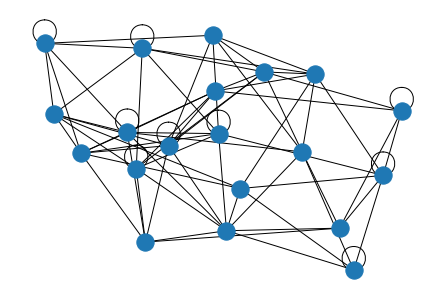

In [ ]:
show_graph(model)

In [ ]:
def test_model(model, dataset, sample_size, load_dir):
    model = load_model_only_from_drive(load_dir, model)

    generated_list = [model.generate() for i in range(sample_size)]
    generated_stats = [compute_graph_statistics(
        nx.adjacency_matrix(
            nx.from_numpy_matrix(
                np.rint(generated.cpu().numpy())
            )
        )
    ) for generated in generated_list]
    print(generated_stats)
    generated_mean_stats = {}
    for k in list(generated_stats[0].keys()):
        generated_mean_stats[k] = sum(list(map(lambda x: x[k], generated_stats))) / len(generated_stats)


    test_sample = np.random.choice(dataset, size=sample_size, replace=False)
    sample_stats = [compute_graph_statistics(
        nx.adjacency_matrix(sample)
    ) for sample in test_sample]

    print(sample_stats)
    sample_mean_stats = {}
    for k in list(sample_stats[0].keys()):
        sample_mean_stats[k] = sum(list(map(lambda x: x[k], sample_stats))) / len(sample_stats)

    diff_stats = {}
    for k in list(generated_mean_stats.keys()):
        diff_stats[k] = abs(generated_mean_stats[k] - sample_mean_stats[k])

    return diff_stats

In [ ]:
test_model(model, data, 60, '/content/gdrive/My Drive/Alaj_output')

[{'d_max': 11.0, 'd_min': 5.0, 'd': 7.3, 'node_num': 20, 'edge_num': 78, 'LCC': 20, 'triangle_count': 44, 'gini': -1.05, 'n_components': 1}, {'d_max': 11.0, 'd_min': 4.0, 'd': 7.3, 'node_num': 20, 'edge_num': 76, 'LCC': 20, 'triangle_count': 59, 'gini': -1.05, 'n_components': 1}, {'d_max': 11.0, 'd_min': 5.0, 'd': 7.7, 'node_num': 20, 'edge_num': 81, 'LCC': 20, 'triangle_count': 63, 'gini': -1.05, 'n_components': 1}, {'d_max': 11.0, 'd_min': 5.0, 'd': 8.35, 'node_num': 20, 'edge_num': 88, 'LCC': 20, 'triangle_count': 76, 'gini': -1.05, 'n_components': 1}, {'d_max': 11.0, 'd_min': 5.0, 'd': 7.95, 'node_num': 20, 'edge_num': 84, 'LCC': 20, 'triangle_count': 59, 'gini': -1.05, 'n_components': 1}, {'d_max': 11.0, 'd_min': 5.0, 'd': 7.75, 'node_num': 20, 'edge_num': 81, 'LCC': 20, 'triangle_count': 70, 'gini': -1.05, 'n_components': 1}, {'d_max': 10.0, 'd_min': 5.0, 'd': 7.95, 'node_num': 20, 'edge_num': 84, 'LCC': 20, 'triangle_count': 70, 'gini': -1.05, 'n_components': 1}, {'d_max': 12.0,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[{'d_max': 5, 'd_min': 3, 'd': 3.5294117647058822, 'node_num': 17, 'edge_num': 30, 'LCC': 17, 'triangle_count': 16, 'gini': -1.0588235294117647, 'n_components': 1}, {'d_max': 7, 'd_min': 2, 'd': 4.5, 'node_num': 20, 'edge_num': 45, 'LCC': 20, 'triangle_count': 22, 'gini': -1.05, 'n_components': 1}, {'d_max': 6, 'd_min': 2, 'd': 3.5, 'node_num': 16, 'edge_num': 28, 'LCC': 16, 'triangle_count': 11, 'gini': -1.0625, 'n_components': 1}, {'d_max': 5, 'd_min': 3, 'd': 3.411764705882353, 'node_num': 17, 'edge_num': 29, 'LCC': 17, 'triangle_count': 15, 'gini': -1.0588235294117647, 'n_components': 1}, {'d_max': 6, 'd_min': 2, 'd': 3.8, 'node_num': 20, 'edge_num': 38, 'LCC': 20, 'triangle_count': 10, 'gini': -1.05, 'n_components': 1}, {'d_max': 6, 'd_min': 3, 'd': 3.789473684210526, 'node_num': 19, 'edge_num': 36, 'LCC': 19, 'triangle_count': 23, 'gini': -1.0526315789473684, 'n_components': 1}, {'d_max': 6, 'd_min': 3, 'd': 4.105263157894737, 'node_num': 19, 'edge_num': 39, 'LCC': 19, 'triangle_

{'LCC': 2.283333333333335,
 'd': 3.861270926499257,
 'd_max': 4.983333333333333,
 'd_min': 1.8166666666666669,
 'edge_num': 46.88333333333333,
 'gini': 0.0064878597637902935,
 'n_components': 0.016666666666666607,
 'node_num': 2.133333333333333,
 'triangle_count': 44.983333333333334}